# Project Goal

#### The goal of this project is to predict housing prices from the ['Ames Housing Dataset'](http://www.amstat.org/publications/jse/v19n3/decock.pdf), involving 79 explanatory variables including continuous, categorical and ordinal data types.

#### The dataset is part of the ['Housing Prices: Advanced Regression Techniques'](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition hosted by Kaggle. Scores are assessed via RMSLE, and scores ranked on the leaderboard.

#### The RMLSE score achieved by this project is 0.12089, placing in the top 23% of scores as of Jan 2019.

#### This notebook will discuss the results and decision-making for the initial data exploration, missing value imputation, feature engineering, feature selection and regression modelling. 

#### The models used to fit the data include Ridge Regression, ElasticNet, KernalRidge and Gradient Boosting.

&nbsp;

Import the modules we will be using for this project

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

Load the train and test data

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Initial data exploration reveals there are 37 numeric type features, and 43 non-numeric features.
The total number of rows is 1460, however the counts for many columns is less than 1460, indicating missing values.
Some features such as 'PoolQC' and 'MiscFeature' have a majority of missing values.

'SalePrice' is the target variable we are trying to predict.

In [32]:
pd.set_option('display.max_columns', None)
print(data.describe(include='all'))
print('Total data dimensions', data.shape)
print('Data dimensions of numeric features', data.select_dtypes(include=[np.number]).shape)

         MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1460.000000     1460  1201.000000    1460.000000   1460    91   
unique          NaN        5          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN     1151          NaN            NaN   1454    50   
mean      56.897260      NaN    70.049958   10516.828082    NaN   NaN   
std       42.300571      NaN    24.284752    9981.264932    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7553.500000    NaN   NaN   
50%       50.000000      NaN    69.000000    9478.500000    NaN   NaN   
75%       70.000000      NaN    80.000000   11601.500000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count      1460        1460      1460      1460  

The 'Id' column is a unique identifier for each row of data, and does not have any predictive power. We can safely remove these columns.

In [4]:
test_id = test['Id']
data = data.drop(columns=['Id'])
test = test.drop(columns=['Id'])

We can check for features with only one unique value, indicating the feature will have no predictive power. As there is no output, all features have more than one unique value.

In [33]:
for column in data:
    if len(data[column].unique()) <= 1:
        print(column)

Pearson correlations between numerical variables can be visualized using a heatmap. Zero represents no correlation. +1.0 indicates perfect positive correlation, 0 represents no correlation, and -1.0 indicates perfect negative correlation.

The heatmap reveals the most correlated numerical features with 'SalePrice' are 'OverallQual' - The overall quality of the property on an ordinal 1-10 scale, and 'GrLivArea' the area of the living spaces above ground.


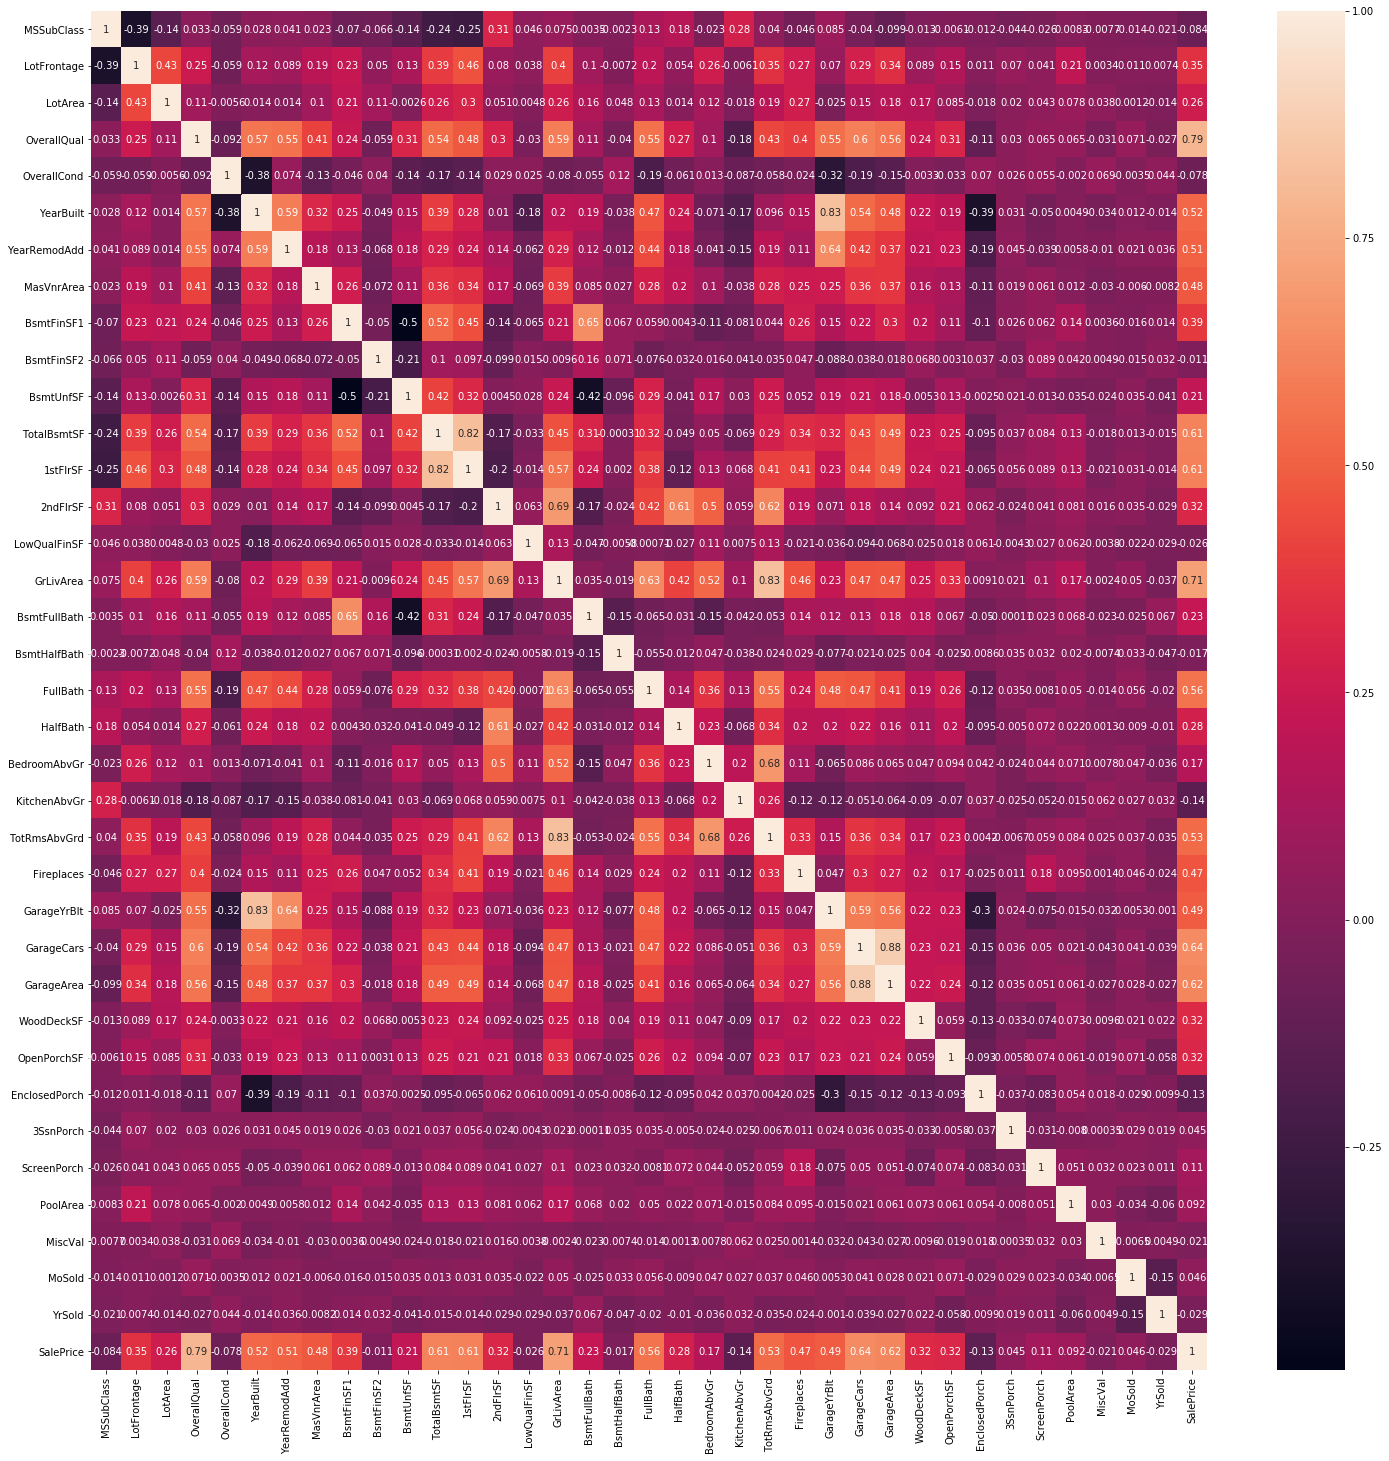

In [37]:
numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()

%matplotlib inline
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlations, annot=True)
plt.show()

When looking at correlations between variables we see that several have corelation values > 0.8. Namely, ('GarageCars' and 'GarageArea'), ('GarageYrBlt' and 'YearBuilt'), and ('GrLivArea' and 'TotRmsAbvGrd'). The presence of collinearity can inflate the variance and cause instability in coefficient estimates, so we will remove one variable from each pair of collinear variables. 

Intuitively, the variables represent the same information, for example, the number of cars and the area of the garage are both giving the same information - the size of the garage. Therefore it is probably safe to remove one of these variables for now.

In [ ]:
data = data.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])
test = test.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


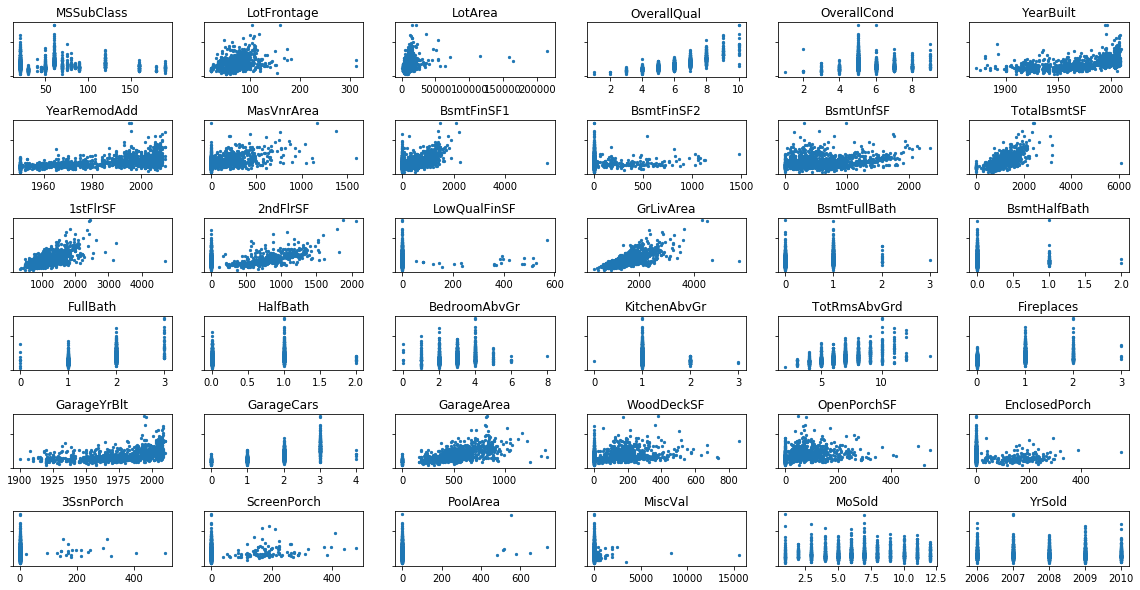

In [42]:
numeric_data = data.select_dtypes(include=[np.number])
print(numeric_data.columns)

%matplotlib inline
f, ax = plt.subplots(6, 6, figsize=(20,10))
for row in range(6):
    for col in range(6):
        idx = col+(6*row)
        if idx < 36:
            x=numeric_data.iloc[:, idx]
            y=numeric_data['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].set_title(numeric_data.columns[idx])
            ax[row, col].set_yticklabels([])

plt.subplots_adjust(hspace=0.8)
plt.show()